In [499]:
# importing libs
import numpy as np
import tensorflow as tf
from keras.layers import Input, Dense, GaussianNoise, Lambda
from keras.models import Model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras import backend as K
import random as rn
from keras.callbacks import EarlyStopping

def frange(x, y, jump):
  while x < y:
    yield x
    x += jump

In [500]:
# defining parameters
k = 8
M = 2**k
# k = np.log2(M)
# k = int(k)
n_channel = 8
R = k/n_channel
print ('M:',M,'k:',k, "n: ", n_channel, "R: ", R)

EbNodB_range = list(frange(-4,8,0.5))

M: 256 k: 8 n:  8 R:  1.0


In [501]:
seed=24
tf.set_random_seed(seed)
rn.seed(seed)
np.random.seed(seed)

In [502]:
#generating data of size N
N = 10000
label = np.random.randint(M,size=N)

In [503]:
# creating one hot encoded vectors
data = []
for i in label:
    temp = np.zeros(M)
    temp[i] = 1
    data.append(temp)

In [504]:
data = np.array(data)
print (data.shape)

(10000, 256)


In [505]:
temp_check = [17,23,45,67,89,96,72,250,350]
for i in temp_check:
    print(label[i],data[i])

115 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
135 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [506]:
# print (int(k/R))
input_signal = Input(shape=(M,))
encoded = Dense(M, activation='relu')(input_signal)
encoded1 = Dense(n_channel, activation='linear')(encoded)
encoded2 = BatchNormalization(center=False, scale=False)(encoded1)
# encoded2 = Lambda(lambda x: 1.0/np.sqrt(2)*K.l2_normalize(x,axis=-1))(encoded2)

EbNo_train = 5.01187 #  coverted 7 db of EbNo
encoded3 = GaussianNoise(np.sqrt(1/(2*R*EbNo_train)))(encoded2)

decoded = Dense(M, activation='relu')(encoded3)
decoded1 = Dense(M, activation='softmax')(decoded)

autoencoder = Model(input_signal, decoded1)
#sgd = SGD(lr=0.001)
autoencoder.compile(optimizer='adam', loss='categorical_crossentropy')

In [507]:
print (autoencoder.summary())

Model: "model_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_48 (InputLayer)        (None, 256)               0         
_________________________________________________________________
dense_99 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_100 (Dense)            (None, 8)                 2056      
_________________________________________________________________
batch_normalization_24 (Batc (None, 8)                 16        
_________________________________________________________________
gaussian_noise_24 (GaussianN (None, 8)                 0         
_________________________________________________________________
dense_101 (Dense)            (None, 256)               2304      
_________________________________________________________________
dense_102 (Dense)            (None, 256)               657

In [508]:
N_val = 1500
val_label = np.random.randint(M,size=N_val)
val_data = []
for i in val_label:
    temp = np.zeros(M)
    temp[i] = 1
    val_data.append(temp)
val_data = np.array(val_data)

In [509]:
early_stop = EarlyStopping(patience=100, restore_best_weights=True, monitor="loss")
autoencoder.fit(data, data,
                epochs=1000,
                batch_size=300,
                validation_data=(val_data, val_data),
               callbacks=[early_stop])

Train on 10000 samples, validate on 1500 samples
Epoch 1/1000
10000/10000 [==============================] - 1s 125us/step - loss: 5.0234 - val_loss: 5.3825
Epoch 2/1000
10000/10000 [==============================] - 0s 33us/step - loss: 3.8398 - val_loss: 4.8158
Epoch 3/1000
10000/10000 [==============================] - 0s 33us/step - loss: 2.5010 - val_loss: 3.7998
Epoch 4/1000
10000/10000 [==============================] - 0s 33us/step - loss: 1.4425 - val_loss: 2.6155
Epoch 5/1000
10000/10000 [==============================] - 0s 32us/step - loss: 0.8196 - val_loss: 1.5723
Epoch 6/1000
10000/10000 [==============================] - 0s 33us/step - loss: 0.4907 - val_loss: 0.8322
Epoch 7/1000
10000/10000 [==============================] - 0s 33us/step - loss: 0.3237 - val_loss: 0.4107
Epoch 8/1000
10000/10000 [==============================] - 0s 33us/step - loss: 0.2417 - val_loss: 0.2006
Epoch 9/1000
10000/10000 [==============================] - 0s 33us/step - loss: 0.1818 - val_

Epoch 75/1000
10000/10000 [==============================] - 0s 37us/step - loss: 0.0159 - val_loss: 2.5882e-05
Epoch 76/1000
10000/10000 [==============================] - 0s 37us/step - loss: 0.0156 - val_loss: 2.6698e-05
Epoch 77/1000
10000/10000 [==============================] - 0s 37us/step - loss: 0.0174 - val_loss: 2.6164e-05
Epoch 78/1000
10000/10000 [==============================] - 0s 36us/step - loss: 0.0188 - val_loss: 2.3976e-05
Epoch 79/1000
10000/10000 [==============================] - 0s 36us/step - loss: 0.0170 - val_loss: 2.1041e-05
Epoch 80/1000
10000/10000 [==============================] - 0s 37us/step - loss: 0.0184 - val_loss: 2.0629e-05
Epoch 81/1000
10000/10000 [==============================] - 0s 37us/step - loss: 0.0173 - val_loss: 2.0157e-05
Epoch 82/1000
10000/10000 [==============================] - 0s 38us/step - loss: 0.0149 - val_loss: 1.7019e-05
Epoch 83/1000
10000/10000 [==============================] - 0s 37us/step - loss: 0.0152 - val_loss: 1.5

10000/10000 [==============================] - 0s 33us/step - loss: 0.0123 - val_loss: 1.2379e-06
Epoch 148/1000
10000/10000 [==============================] - 0s 34us/step - loss: 0.0109 - val_loss: 9.5804e-07
Epoch 149/1000
10000/10000 [==============================] - 0s 34us/step - loss: 0.0133 - val_loss: 8.7992e-07
Epoch 150/1000
10000/10000 [==============================] - 0s 34us/step - loss: 0.0135 - val_loss: 9.1251e-07
Epoch 151/1000
10000/10000 [==============================] - 0s 33us/step - loss: 0.0123 - val_loss: 9.9301e-07
Epoch 152/1000
10000/10000 [==============================] - 0s 34us/step - loss: 0.0127 - val_loss: 1.3513e-06
Epoch 153/1000
10000/10000 [==============================] - 0s 33us/step - loss: 0.0137 - val_loss: 1.2677e-06
Epoch 154/1000
10000/10000 [==============================] - 0s 34us/step - loss: 0.0117 - val_loss: 9.0384e-07
Epoch 155/1000
10000/10000 [==============================] - 0s 33us/step - loss: 0.0121 - val_loss: 9.1537e-0

10000/10000 [==============================] - 0s 34us/step - loss: 0.0096 - val_loss: 1.2581e-07
Epoch 220/1000
10000/10000 [==============================] - 0s 34us/step - loss: 0.0086 - val_loss: 1.3145e-07
Epoch 221/1000
10000/10000 [==============================] - 0s 33us/step - loss: 0.0080 - val_loss: 1.3638e-07
Epoch 222/1000
10000/10000 [==============================] - 0s 35us/step - loss: 0.0117 - val_loss: 1.5028e-07
Epoch 223/1000
10000/10000 [==============================] - 0s 35us/step - loss: 0.0090 - val_loss: 1.2469e-07
Epoch 224/1000
10000/10000 [==============================] - 0s 34us/step - loss: 0.0126 - val_loss: 1.4281e-07
Epoch 225/1000
10000/10000 [==============================] - 0s 35us/step - loss: 0.0095 - val_loss: 1.4464e-07
Epoch 226/1000
10000/10000 [==============================] - 0s 34us/step - loss: 0.0119 - val_loss: 1.2279e-07
Epoch 227/1000
10000/10000 [==============================] - 0s 35us/step - loss: 0.0109 - val_loss: 1.1730e-0

10000/10000 [==============================] - 0s 36us/step - loss: 0.0108 - val_loss: 4.1326e-08
Epoch 292/1000
10000/10000 [==============================] - 0s 37us/step - loss: 0.0119 - val_loss: 4.0372e-08
Epoch 293/1000
10000/10000 [==============================] - 0s 37us/step - loss: 0.0118 - val_loss: 2.0663e-08
Epoch 294/1000
10000/10000 [==============================] - 0s 36us/step - loss: 0.0144 - val_loss: 3.1074e-08
Epoch 295/1000
10000/10000 [==============================] - 0s 37us/step - loss: 0.0101 - val_loss: 2.9564e-08
Epoch 296/1000
10000/10000 [==============================] - 0s 36us/step - loss: 0.0138 - val_loss: 3.0518e-08
Epoch 297/1000
10000/10000 [==============================] - 0s 36us/step - loss: 0.0117 - val_loss: 3.6875e-08
Epoch 298/1000
10000/10000 [==============================] - 0s 36us/step - loss: 0.0110 - val_loss: 4.4664e-08
Epoch 299/1000
10000/10000 [==============================] - 0s 37us/step - loss: 0.0133 - val_loss: 5.0147e-0

10000/10000 [==============================] - 0s 35us/step - loss: 0.0110 - val_loss: 2.0822e-08
Epoch 364/1000
10000/10000 [==============================] - 0s 35us/step - loss: 0.0108 - val_loss: 1.6689e-08
Epoch 365/1000
10000/10000 [==============================] - 0s 35us/step - loss: 0.0122 - val_loss: 1.1603e-08
Epoch 366/1000
10000/10000 [==============================] - 0s 34us/step - loss: 0.0098 - val_loss: 1.3987e-08
Epoch 367/1000
10000/10000 [==============================] - 0s 34us/step - loss: 0.0130 - val_loss: 8.1062e-09
Epoch 368/1000
10000/10000 [==============================] - 0s 34us/step - loss: 0.0105 - val_loss: 1.3431e-08
Epoch 369/1000
10000/10000 [==============================] - 0s 34us/step - loss: 0.0116 - val_loss: 1.2716e-08
Epoch 370/1000
10000/10000 [==============================] - 0s 34us/step - loss: 0.0121 - val_loss: 1.9550e-08
Epoch 371/1000
10000/10000 [==============================] - 0s 34us/step - loss: 0.0104 - val_loss: 1.4782e-0

10000/10000 [==============================] - 0s 34us/step - loss: 0.0130 - val_loss: 1.4385e-08


In [510]:
from keras.models import load_model
#autoencoder.save('4_7_symbol_autoencoder_v_best.model')

In [511]:
#autoencoder_loaded = load_model('4_7_symbol_autoencoder_v_best.model')

In [512]:
encoder = Model(input_signal, encoded2)

In [513]:
encoded_input = Input(shape=(n_channel,))

deco = autoencoder.layers[-2](encoded_input)
deco = autoencoder.layers[-1](deco)
# create the decoder model
decoder = Model(encoded_input, deco)

In [514]:
N = 45000
test_label = np.random.randint(M,size=N)
test_data = []

for i in test_label:
    temp = np.zeros(M)
    temp[i] = 1
    test_data.append(temp)
    
test_data = np.array(test_data)

In [515]:
temp_test = 6
print (test_data[temp_test][test_label[temp_test]],test_label[temp_test])

1.0 87


In [516]:
autoencoder

In [517]:
ber = [None]*len(EbNodB_range)
for n in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[n]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise_mean = 0
    no_errors = 0
    nn = N
    noise = noise_std * np.random.randn(nn,n_channel)
    encoded_signal = encoder.predict(test_data) 
    final_signal = encoded_signal + noise
    pred_final_signal =  decoder.predict(final_signal)
    pred_output = np.argmax(pred_final_signal,axis=1)
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    ber[n] = no_errors / nn 
    print ('SNR:',EbNodB_range[n],'BER:',ber[n])

SNR: -4 BER: 0.7868888888888889
SNR: -3.5 BER: 0.7576444444444445
SNR: -3.0 BER: 0.7214888888888888
SNR: -2.5 BER: 0.6813333333333333
SNR: -2.0 BER: 0.6387111111111111
SNR: -1.5 BER: 0.5897555555555556
SNR: -1.0 BER: 0.5437111111111111
SNR: -0.5 BER: 0.4838
SNR: 0.0 BER: 0.4261333333333333
SNR: 0.5 BER: 0.372
SNR: 1.0 BER: 0.31244444444444447
SNR: 1.5 BER: 0.2637111111111111
SNR: 2.0 BER: 0.2098888888888889
SNR: 2.5 BER: 0.16262222222222222
SNR: 3.0 BER: 0.12304444444444444
SNR: 3.5 BER: 0.09033333333333333
SNR: 4.0 BER: 0.06246666666666666
SNR: 4.5 BER: 0.04084444444444445
SNR: 5.0 BER: 0.02668888888888889
SNR: 5.5 BER: 0.01671111111111111
SNR: 6.0 BER: 0.008977777777777777
SNR: 6.5 BER: 0.0054444444444444445
SNR: 7.0 BER: 0.0024222222222222223
SNR: 7.5 BER: 0.0013333333333333333


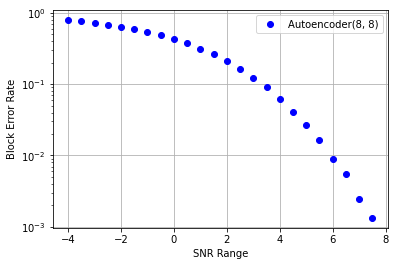

In [518]:
import matplotlib.pyplot as plt
plt.plot(EbNodB_range, ber, 'bo',label='Autoencoder({}, {})'.format(n_channel, k))
#plt.plot(list(EbNodB_range), ber_theory, 'ro-',label='BPSK BER')
plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('Block Error Rate')
plt.grid()
plt.legend(loc='upper right',ncol = 1)
plt.savefig('AutoEncoder_{}_{}_BER.png'.format(n_channel, k))
plt.show()

In [519]:
scatter_plot = []
for i in range(0,M):
    temp = np.zeros(M)
    temp[i] = 1
    scatter_plot.append(encoder.predict(np.expand_dims(temp,axis=0)))
scatter_plot = 1.5/2*np.array(scatter_plot)


In [520]:
# ploting constellation diagram
import matplotlib.pyplot as plt
scatter_plot = scatter_plot.reshape(M,2,1)
plt.scatter(scatter_plot[:,0, :],scatter_plot[:,1, :])
#plt.axis((-2.5,2.5,-2.5,2.5))
plt.grid()
plt.xlabel('I Axis')
plt.ylabel('Q Axis')
plt.savefig('AutoEncoder_{}_{}_Constellation.png'.format(n_channel, k))
plt.show()

ValueError: cannot reshape array of size 2048 into shape (256,2,1)

In [ ]:
scatter_plot.shape